In [3]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [5]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [20]:
import  os  as  os
from os  import  *
import  random

In [8]:
PATH = "/home/paperspace/.kaggle/competitions/plant-seedlings-classification/"
sz=224

In [9]:
!ls {PATH}

sample_submission.csv	   test      train
sample_submission.csv.zip  test.zip  train.zip


In [10]:
torch.cuda.is_available()

True

In [11]:
torch.backends.cudnn.enabled

True

In [12]:
os.listdir(PATH)

['train.zip',
 'sample_submission.csv',
 'test',
 'sample_submission.csv.zip',
 'train',
 'test.zip']

In [13]:
os.listdir(f'{PATH}train/')

['Cleavers',
 'Sugar beet',
 'Scentless Mayweed',
 'Loose Silky-bent',
 'Maize',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Fat Hen',
 'Charlock',
 'Common wheat',
 'Black-grass',
 'Common Chickweed']

In [14]:
files = os.listdir(f'{PATH}train/Cleavers')[:5]
files

['0bec204c7.png',
 'd8597aa6a.png',
 '7e8212b65.png',
 '58b68b1ea.png',
 'ef4a36963.png']

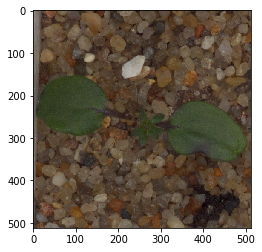

In [15]:
img = plt.imread(f'{PATH}train/Cleavers/{files[0]}')
plt.imshow(img);

In [16]:
img.shape

(512, 512, 3)

In [26]:
def copy_to_valid(chosen_files,class_dir):
    for i in range (len(chosen_files)):
        !mv "{PATH}/train/{class_dir}/{chosen_files[i]}" "{PATH}/valid/{class_dir}"

In [27]:
classes=!ls {PATH}/train

In [28]:
for classname in classes:
    os.makedirs(f'{PATH}/valid/{classname}', exist_ok=True)
    list_of_files = !ls "{PATH}/train/{classname}"
    random.shuffle(list_of_files)
    n_files_moved=int(len(list_of_files)*0.2)
    selected_files = [list_of_files[m] for m in range(n_files_moved)]
    copy_to_valid(selected_files,classname)

In [24]:
#img[:4,:4]

In [33]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

100%|██████████| 27/27 [00:07<00:00,  3.60it/s]


epoch      trn_loss   val_loss   accuracy                 
    0      1.700261   0.973484   0.675279  
    1      1.213285   0.80485    0.738696                 



[array([0.80485]), 0.7386964184007292]

In [34]:
# This is the label for a val data
data.val_y

array([ 0,  0,  0, ..., 11, 11, 11])

In [35]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [36]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(1703, 12)

In [32]:
log_preds[:10]

array([[ -3.1196 ,  -5.57144,  -3.70861,  -3.2698 ,  -1.59384,  -1.64294,  -1.11139,  -3.63993,  -3.39327,
         -2.81197,  -5.85442,  -3.19346],
       [ -2.28132,  -7.86493,  -6.14831,  -7.33322,  -3.73059,  -4.76202,  -0.16804,  -7.3351 ,  -4.75835,
         -6.92546,  -8.07831,  -5.06698],
       [ -1.74513,  -7.55251,  -6.79908,  -5.83861,  -3.13898,  -5.08478,  -0.3055 ,  -7.44079,  -4.21104,
         -6.63348,  -8.06181,  -4.04534],
       [ -0.78686,  -8.73772,  -6.64388,  -8.86656,  -2.70288,  -3.84927,  -0.85933,  -3.52009,  -9.22379,
         -8.89952,  -7.91232,  -6.74992],
       [ -0.27344,  -9.37237, -11.90112, -11.09968,  -2.67499, -10.02903,  -1.80184,  -5.33486,  -8.45687,
        -10.30299,  -9.27012, -10.54915],
       [ -1.41228,  -5.21938,  -6.52208,  -4.37646,  -3.34337,  -5.55387,  -0.42707,  -6.20274,  -4.69518,
         -5.61343,  -3.52887,  -6.72471],
       [ -0.86643,  -8.63397,  -7.66356,  -4.44768,  -7.84413,  -5.0567 ,  -0.6064 ,  -8.96123,  -5.01691,

In [37]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [38]:
lrf=learn.lr_find()

 54%|█████▍    | 26/48 [00:00<00:00, 38.46it/s, loss=2.96]


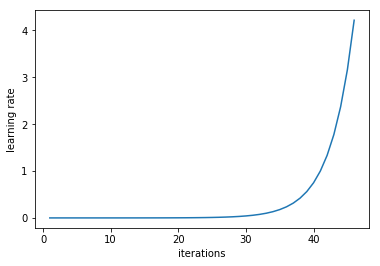

In [39]:
learn.sched.plot_lr()

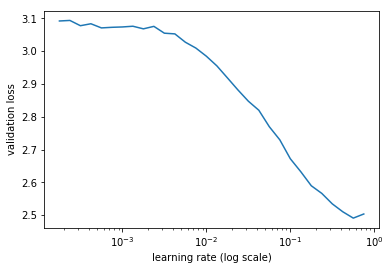

In [40]:
learn.sched.plot()

In [43]:
# Using transforms_top_down here as photos are taken from above
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_top_down, max_zoom=1.1)

In [42]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [44]:
ims = np.stack([get_augs() for i in range(6)])

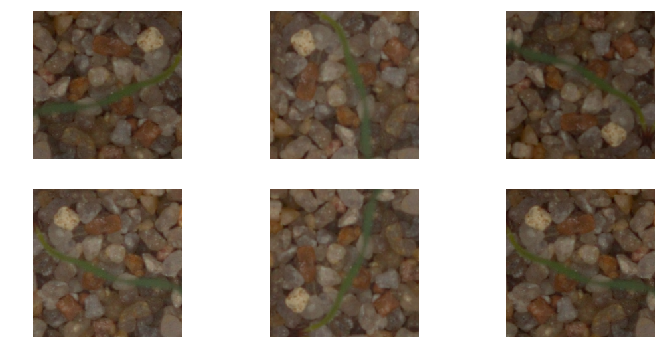

In [45]:
plots(ims, rows=2)

In [46]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [47]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.710259   1.035003   0.65825   



[array([1.035]), 0.6582501470097639]

In [48]:
learn.precompute=False

In [50]:
learn.fit(1e-2, 6, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.945762   0.725308   0.739871  
    1      0.910129   0.67511    0.768644                  
    2      0.87562    0.66156    0.770405                  
    3      0.842596   0.624292   0.786847                  
    4      0.828802   0.615663   0.777452                  
    5      0.80087    0.596471   0.788021                  



[array([0.59647]), 0.7880211393061765]

In [51]:
learn.save('224_lastlayer')

In [52]:
learn.load('224_lastlayer')

In [53]:


learn.unfreeze()

In [54]:
lr=np.array([1e-4,1e-3,1e-2])

In [56]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.234613   0.212715   0.921903  
    1      0.23079    0.201741   0.926013                  
    2      0.205918   0.198354   0.925426                  
    3      0.211361   0.196336   0.927775                  
    4      0.19241    0.188942   0.933059                  
    5      0.177993   0.183713   0.933647                  
    6      0.155551   0.18296    0.931298                  



[array([0.18296]), 0.9312977099586639]

In [57]:
learn.save('224_all')

In [58]:
learn.load('224_all')

In [60]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [61]:
# Confusion Matrix
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [62]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)